<a href="https://colab.research.google.com/github/alexanderknysh/adcpml/blob/main/adcpml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A machine learning algorithm for near-shore ADCP data processing

The following machine learning study aims to select several typical and several anomalous loadcases (about 20-30 loadcases in total) from a detailed ADCP datasets obtained at the Wood Island research site, Maine, USA. Two ADCPs measured water depth, significant wave height and period, as well as north and east projections of current velocity profiles (15 minute averages) during a half of a month period. More details on the research can be found in [Section 3.2 of this paper](https://github.com/alexanderknysh/adcpml/blob/main/paper.pdf).

## Data formatting
Before we start processing the ADCP datasets, let's first list the libraries needed for the analysis

In [58]:
# required libraries
import pandas              as pd
import numpy               as np
import math                as m
import matplotlib.pyplot   as plt
import plotly.express      as px
from collections           import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster       import KMeans
from sklearn               import metrics


and define a function that will format velocity profiles to the total fluid energy in the upper ocean layers:

In [59]:
# function that format velocity profile datasets
def format_profile(data, top): 
  output = np.empty((0,top))
  for i in range(data.shape[0]):
    row = data[i]
    row = row[np.logical_not(np.isnan(row))]
    row = row[-top:]
    row = np.dot(row, row)
    output = np.append(output, row)
  return output

Next, upload the datasets from the [following GitHub repository](https://github.com/alexanderknysh/adcpml):

In [60]:
# upload datasets common for both adcps:  wave properties and water depth
adcpdata = pd.read_excel('https://github.com/alexanderknysh/adcpml/blob/main/data_adcp_cm.xlsx?raw=true')

# upload velocity dataset: west and east adpc profiles
west_vx  = pd.read_excel('https://github.com/alexanderknysh/adcpml/blob/main/west_adcp_vx.xlsx?raw=true')
west_vy  = pd.read_excel('https://github.com/alexanderknysh/adcpml/blob/main/west_adcp_vy.xlsx?raw=true')
east_vx  = pd.read_excel('https://github.com/alexanderknysh/adcpml/blob/main/east_adcp_vx.xlsx?raw=true')
east_vy  = pd.read_excel('https://github.com/alexanderknysh/adcpml/blob/main/east_adcp_vy.xlsx?raw=true')

# other important data
samples = range(0, adcpdata.shape[0]) # range of field samples
alpha   = 13*m.pi/180                 # major axis of tidal ellipse (13 degrees)
cells   = 9                           # number of velocity measurement cells

In ocean engineering, tidal-driven current velocities are usually represented in terms of projections on major and minor axes of a tidal ellipse. In this study, we are mostly interested in the major projections since they have the highest absolute values of current velocities. Both west and east major velocity profiles are converted to the energy values that represent total kinetic energy in the upper water layers (4 meters deep). This also reduces number of features we have to deal with in the future.

In [61]:
# project the velocity profiles on the major axis of the tidal ellipse
# save as numpy array to ease further formatting
# convert profiles to relative energy
west_major = west_vx * m.cos(alpha) - west_vy * m.sin(alpha)
east_major = east_vx * m.cos(alpha) - east_vy * m.sin(alpha)
west_major = west_major.to_numpy()
east_major = east_major.to_numpy()
adcpdata['WestEnergy'] = format_profile(west_major, cells)
adcpdata['EastEnergy'] = format_profile(east_major, cells)

# display the resulting dataset
display(adcpdata)

,Date,WaterDepth,WaveHeight,WavePeriod,WestEnergy,EastEnergy
0,2019-05-16 14:15:00.000,9.475,0.235,11.075,0.174540,0.136834
1,2019-05-16 14:30:00.000,9.395,0.250,12.150,0.271423,0.177364
2,2019-05-16 14:44:59.990,9.289,0.240,11.370,0.249177,0.214879
3,2019-05-16 14:59:59.985,9.160,0.235,11.555,0.355531,0.250243
4,2019-05-16 15:14:59.980,9.007,0.210,11.640,0.471080,0.328769
...,...,...,...,...,...,...
1157,2019-05-28 15:29:54.215,7.275,0.275,8.780,0.025099,0.019459
1158,2019-05-28 15:44:54.210,7.176,0.260,8.640,0.063899,0.029413
1159,2019-05-28 15:59:54.205,7.083,0.260,8.660,0.072142,0.073600
1160,2019-05-28 16:14:54.200,7.040,0.280,8.360,0.097749,0.094061


Let's now visualize the final dataset using Matplotlib:

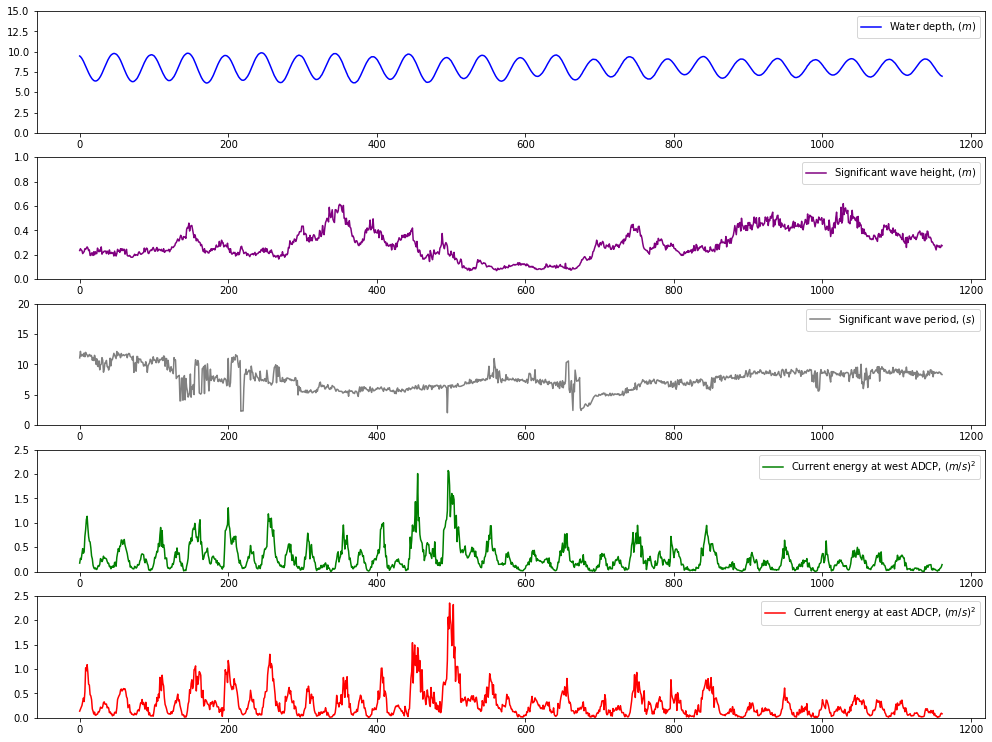

In [62]:
# visualize the adcp data
fig, axs = plt.subplots(5, figsize=(17, 13))

axs[0].plot(samples, adcpdata.iloc[:,1], c='blue', label='Water depth, $(m)$')
axs[0].set_ylim([0, 15])
axs[0].legend(loc='upper right')

axs[1].plot(samples, adcpdata.iloc[:,2], c='purple', label='Significant wave height, $(m)$')
axs[1].set_ylim([0, 1])
axs[1].legend(loc='upper right')

axs[2].plot(samples, adcpdata.iloc[:,3], c='gray', label='Significant wave period, $(s)$')
axs[2].set_ylim([0, 20])
axs[2].legend(loc='upper right')

axs[3].plot(samples, adcpdata.iloc[:,4], c='green', label='Current energy at west ADCP, $(m/s)^2$')
axs[3].set_ylim([0, 2.5])
axs[3].legend(loc='upper right')

axs[4].plot(samples, adcpdata.iloc[:,5], c='red', label='Current energy at east ADCP, $(m/s)^2$')
axs[4].set_ylim([0, 2.5])
axs[4].legend(loc='upper right')

plt.show()

## Data scaling

Even though we have processed the raw ADCP data, it must be still modified before using a clustering algorithm. The problem that is ranges of the feature values vary significantly, and it may cause machine learning algorythms to perform poorly. Thus, the so-called **Min-Max scaling** is applied to make all features vary from 0 to 1 (normalization) since there are no significant outliers in the dataset.

In [63]:
# remove the date column and apply min-max scaling
adcpdata_nodate = adcpdata.drop('Date', axis='columns')
scaler = StandardScaler()
scaler.fit(adcpdata_nodate)
adcpdata_scaled = scaler.fit_transform(adcpdata_nodate)
adcpdata_scaled = pd.DataFrame(adcpdata_scaled, columns=adcpdata_nodate.columns)

# display scaled data
display(adcpdata_scaled)

,WaterDepth,WaveHeight,WavePeriod,WestEnergy,EastEnergy
0,1.422928,-0.449727,1.936302,-0.387866,-0.515059
1,1.343870,-0.326437,2.536732,-0.033365,-0.373893
2,1.239117,-0.408630,2.101071,-0.114764,-0.243228
3,1.111635,-0.449727,2.204401,0.274392,-0.120053
4,0.960436,-0.655209,2.251877,0.697193,0.153459
...,...,...,...,...,...
1157,-0.751181,-0.120955,0.654453,-0.934683,-0.923883
1158,-0.849016,-0.244245,0.576258,-0.792711,-0.889214
1159,-0.940921,-0.244245,0.587428,-0.762548,-0.735306
1160,-0.983415,-0.079859,0.419867,-0.668851,-0.664039


Take a look at the scaled data.

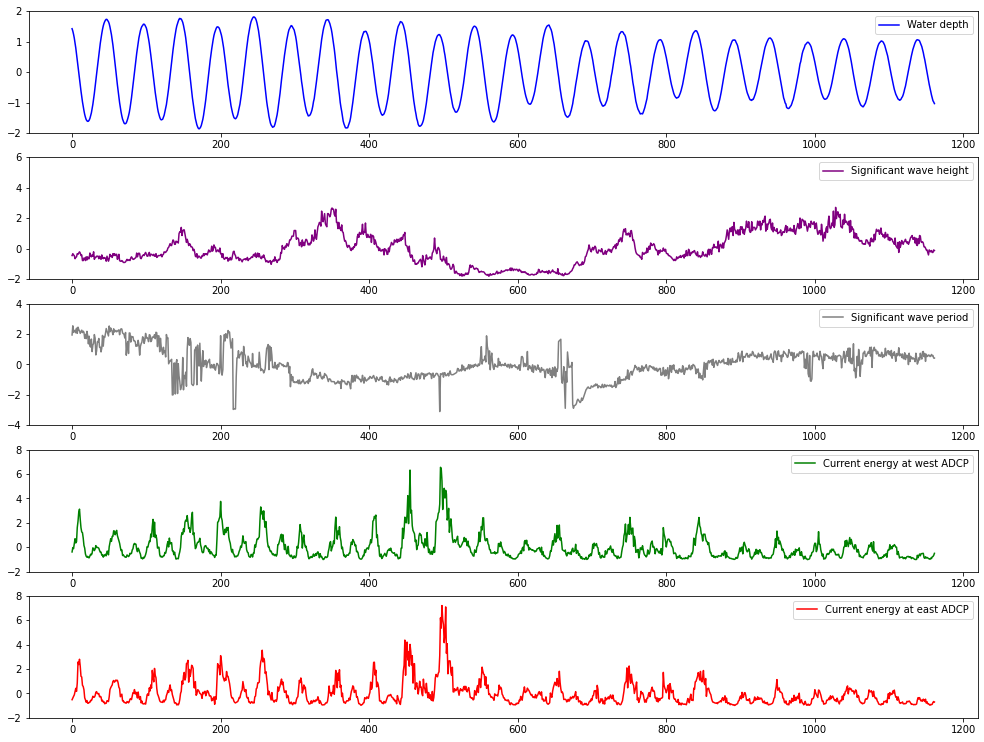

In [64]:
# visualize the adcp data
fig, axs = plt.subplots(5, figsize=(17, 13))

axs[0].plot(samples, adcpdata_scaled.iloc[:,0], c='blue', label='Water depth')
axs[0].set_ylim([-2, 2])
axs[0].legend(loc='upper right')

axs[1].plot(samples, adcpdata_scaled.iloc[:,1], c='purple', label='Significant wave height')
axs[1].set_ylim([-2, 6])
axs[1].legend(loc='upper right')

axs[2].plot(samples, adcpdata_scaled.iloc[:,2], c='gray', label='Significant wave period')
axs[2].set_ylim([-4, 4])
axs[2].legend(loc='upper right')

axs[3].plot(samples, adcpdata_scaled.iloc[:,3], c='green', label='Current energy at west ADCP')
axs[3].set_ylim([-2, 8])
axs[3].legend(loc='upper right')

axs[4].plot(samples, adcpdata_scaled.iloc[:,4], c='red', label='Current energy at east ADCP')
axs[4].set_ylim([-2, 8])
axs[4].legend(loc='upper right')

plt.show()

While there is not that much correlation between wated depth, significant wave height and significant wave period, the connection between water depth and current energy is very clear. Let's zoom in to see high and low tides:

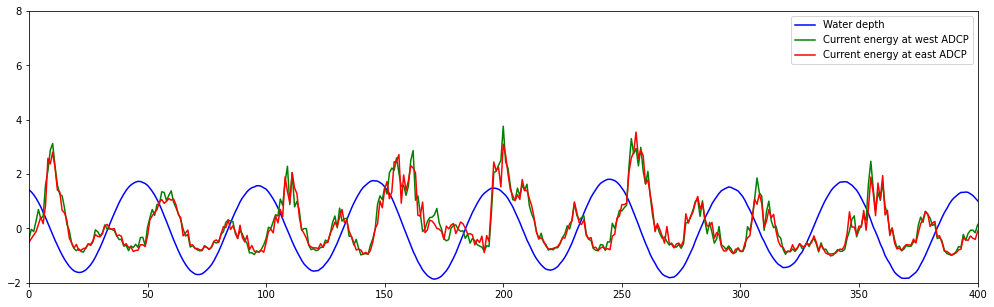

In [65]:
# water depth vs current energy
fig, axs = plt.subplots(figsize=(17, 5))

axs.plot(samples, adcpdata_scaled.iloc[:,0], c='blue', label='Water depth')
axs.plot(samples, adcpdata_scaled.iloc[:,3], c='green', label='Current energy at west ADCP')
axs.plot(samples, adcpdata_scaled.iloc[:,4], c='red', label='Current energy at east ADCP')
axs.set_xlim([0, 400])
axs.set_ylim([-2, 8])
axs.legend(loc='upper right')

plt.show()

## Principle component analysis

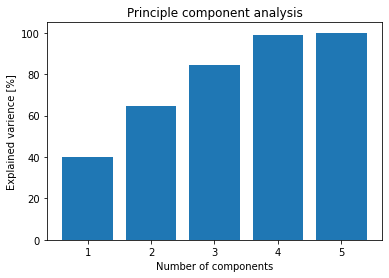

In [66]:
# principle component analysis
variance = []
dimensions = range(1, len(adcpdata_scaled.columns)+1)

# test different number of principal components
for i in dimensions:
  pca = PCA(n_components=i)
  adcpdata_pca = pca.fit_transform(adcpdata_scaled)
  variance.append(sum(pca.explained_variance_ratio_))

# total variance in percentages
variance = [100 * value for value in variance]

# variance bar plot
plt.bar(dimensions, variance)
plt.xlabel("Number of components")
plt.ylabel("Explained varience [%]")
plt.title("Principle component analysis")
plt.show()

Select 3 principal components.

In [67]:
# select 3 principal components
pca = PCA(n_components=3)
adcpdata_pca = pca.fit_transform(adcpdata_scaled)

# k-means clustering, identify the best k
# with elbow method and silhouette method
clusters = range(2,31)
kmeans = []
labels = []
inertia = []
silhouette = []
cluster_delta = []

for k in clusters:
  kmeans.append(KMeans(n_clusters=k).fit(adcpdata_pca))
  labels.append(kmeans[k-2].fit_predict(adcpdata_pca))
  inertia.append(kmeans[k-2].inertia_)
  silhouette.append(metrics.silhouette_score(adcpdata_pca, kmeans[k-2].labels_))

Plot Silhouette score

Text(0.5, 1.0, 'Silhouette Method')

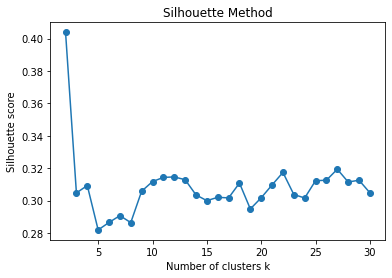

In [68]:
# plot silhouette score
plt.plot(clusters, silhouette, '-o')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method')

Elbow method

Text(0.5, 1.0, 'Elbow Method')

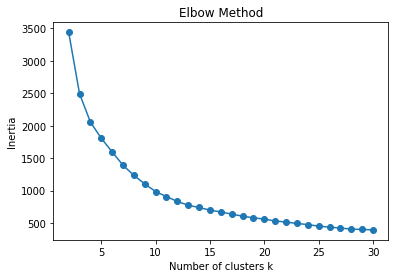

In [69]:
# plot elbow method
plt.plot(clusters, inertia, '-o')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.title('Elbow Method')

Inertia increace

Text(0.5, 1.0, 'Elbow Method')

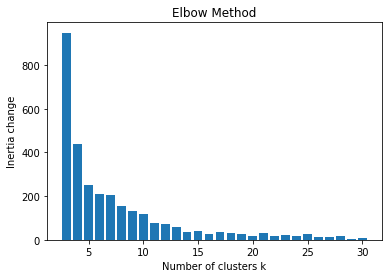

In [70]:
# plot inertia change at each step
plt.bar(np.delete(clusters, 0), -np.diff(inertia))
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia change')
plt.title('Elbow Method')

Select 10 clusters and convert to pandas dataframe:

In [71]:
# selected 10 clusters and create corresponding pandas dataframe
clusters_pca = 10
colormap = labels[clusters_pca-2]+1
adcpdata_pca = pd.DataFrame(adcpdata_pca, columns = ['PC1','PC2','PC3'])    
adcpdata_pca['Cluster'] = colormap

# display data in terms of principal components (PC)
display(adcpdata_pca)

,PC1,PC2,PC3,Cluster
0,-0.542901,0.170293,-1.957296,9
1,-0.251878,0.075295,-2.576086,9
2,-0.188105,0.063022,-2.123341,9
3,0.165864,-0.039788,-2.223830,7
4,0.684078,-0.235824,-2.242043,7
...,...,...,...,...
1157,-1.300526,-0.932942,-0.389172,10
1158,-1.152360,-1.046499,-0.283786,10
1159,-1.028734,-1.102536,-0.288122,10
1160,-0.946982,-0.972762,-0.161716,10


Interactive plot:

In [72]:
fig = px.scatter_3d(adcpdata_pca, x='PC1', y='PC2', z='PC3', color='Cluster', width=1000, height=700)
fig.show()

Check 2 and 10 clusters.

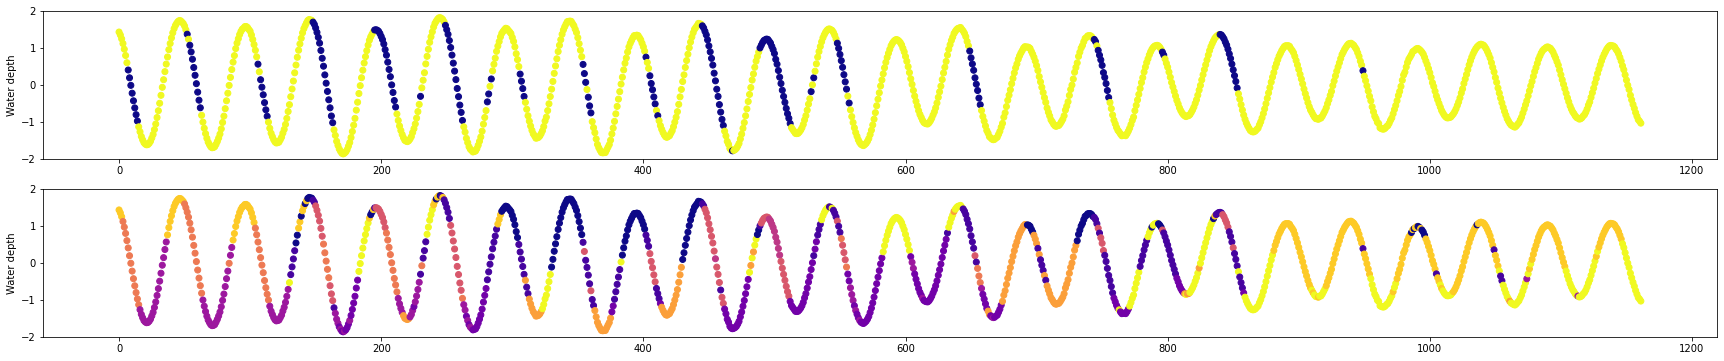

In [73]:
# visualize the adcp data
fig, axs = plt.subplots(2, figsize=(30, 6))

axs[0].scatter(x=samples, y=adcpdata_scaled.iloc[:,0], c=labels[0], cmap='plasma')
axs[0].set_ylabel('Water depth')
axs[0].set_ylim([-2, 2])

axs[1].scatter(x=samples, y=adcpdata_scaled.iloc[:,0], c=colormap, cmap='plasma')
axs[1].set_ylabel('Water depth')
axs[1].set_ylim([-2, 2])

plt.show()

Detailed view on each of 9 clusters.

In [74]:
# new binary colormaps for every cluster
clustermaps = []

for i in range(clusters_pca):
  tempmap = list(colormap)
  for j in samples:
    if tempmap[j]!=i+1:
      tempmap[j]=0
  clustermaps.append(tempmap)

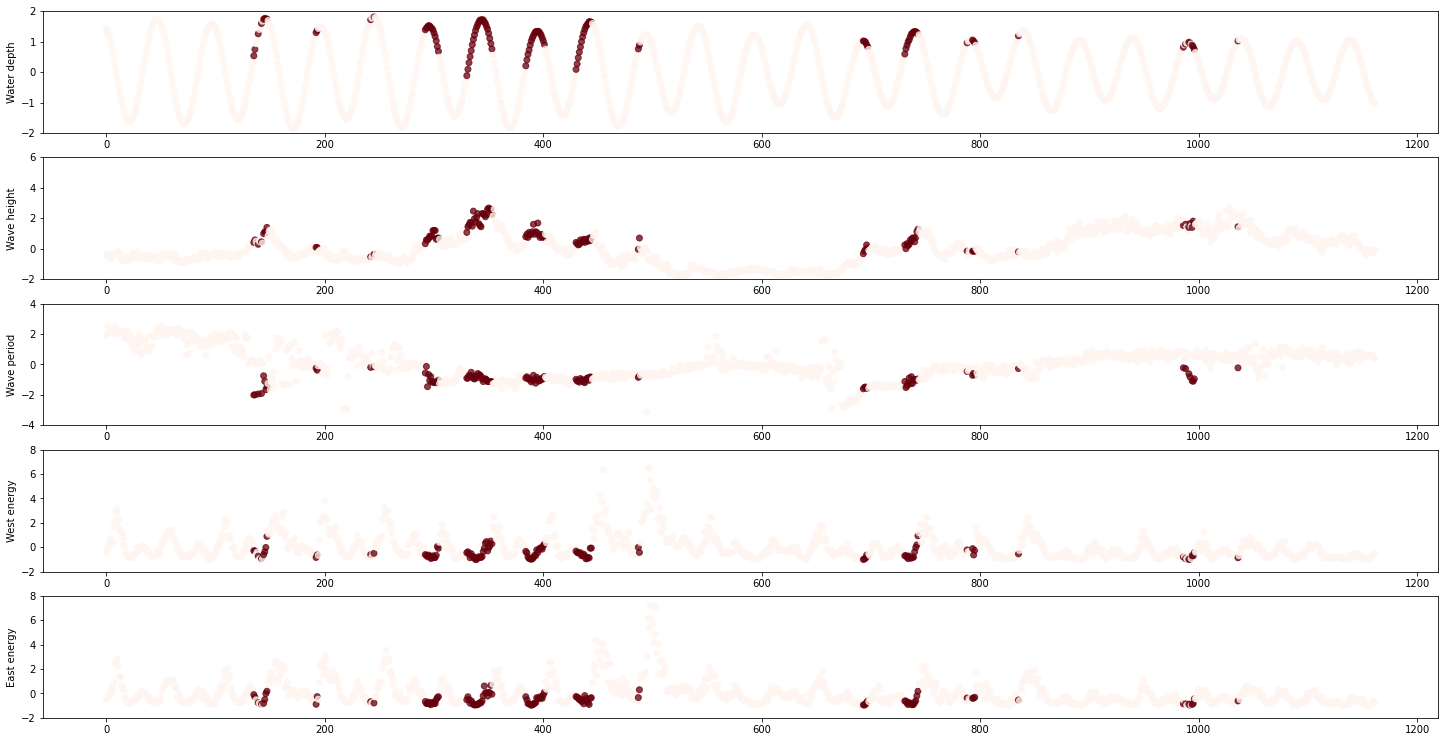

In [75]:
# visualize the adcp data
cluster_plot = 1

fig, axs = plt.subplots(5, figsize=(25, 13))

axs[0].scatter(x=samples, y=adcpdata_scaled.iloc[:,0], c=clustermaps[cluster_plot-1], cmap='Reds', alpha=0.75)
axs[0].set_ylabel('Water depth')
axs[0].set_ylim([-2, 2])

axs[1].scatter(x=samples, y=adcpdata_scaled.iloc[:,1], c=clustermaps[cluster_plot-1], cmap='Reds', alpha=0.75)
axs[1].set_ylabel('Wave height')
axs[1].set_ylim([-2, 6])

axs[2].scatter(x=samples, y=adcpdata_scaled.iloc[:,2], c=clustermaps[cluster_plot-1], cmap='Reds', alpha=0.75)
axs[2].set_ylabel('Wave period')
axs[2].set_ylim([-4, 4])

axs[3].scatter(x=samples, y=adcpdata_scaled.iloc[:,3], c=clustermaps[cluster_plot-1], cmap='Reds', alpha=0.75)
axs[3].set_ylabel('West energy')
axs[3].set_ylim([-2, 8])

axs[4].scatter(x=samples, y=adcpdata_scaled.iloc[:,4], c=clustermaps[cluster_plot-1], cmap='Reds', alpha=0.75)
axs[4].set_ylabel('East energy')
axs[4].set_ylim([-2, 8])

plt.show()

In [76]:
# add the cluster column and calculate mean over each cluster
adcpdata_nodate['Cluster'] = colormap
adcpdata['Cluster'] = colormap
adcpdata_typical = adcpdata_nodate.groupby('Cluster')[['WaterDepth', 'WaveHeight', 'WavePeriod', 'WestEnergy', 'EastEnergy']].mean()

display(adcpdata_typical)

,WaterDepth,WaveHeight,WavePeriod,WestEnergy,EastEnergy
Cluster,,,,,
1,9.177391,0.404261,5.862609,0.137741,0.125368
2,8.397453,0.280820,6.777930,0.449922,0.449924
3,6.984786,0.149517,7.101931,0.282552,0.298678
4,6.896707,0.204837,10.018261,0.212131,0.213932
5,8.750100,0.205500,6.410000,1.649041,1.832343
6,8.504707,0.271933,6.505200,0.880137,0.909515
7,8.116917,0.225333,11.021250,0.599850,0.596112
8,7.307373,0.262696,4.943814,0.142420,0.139793
9,8.702251,0.403288,8.821027,0.158685,0.149175


In [77]:
indices = []

for j in range(clusters_pca):
  dist = kmeans[clusters_pca-2].transform((adcpdata_pca.iloc[: , :-1]).to_numpy())[:, j]
  indices.append(min(range(len(dist)), key=dist.__getitem__))

display(adcpdata.iloc[indices])

,Date,WaterDepth,WaveHeight,WavePeriod,WestEnergy,EastEnergy,Cluster
439,2019-05-21 03:59:57.805,9.549,0.365,5.820,0.022162,0.163124,1
546,2019-05-22 06:44:57.270,9.387,0.130,7.365,0.312589,0.471319,2
265,2019-05-19 08:29:58.675,6.573,0.190,7.000,0.298709,0.336520,3
215,2019-05-18 19:59:58.925,6.787,0.205,10.060,0.172660,0.179855,4
455,2019-05-21 07:59:57.725,8.142,0.235,6.075,2.010858,1.440629,5
202,2019-05-18 16:44:58.990,9.148,0.220,6.350,0.885962,0.861600,6
207,2019-05-18 17:59:58.965,8.256,0.220,11.225,0.608330,0.592228,7
710,2019-05-23 23:44:56.450,7.183,0.275,5.055,0.160146,0.061208,8
926,2019-05-26 05:44:55.370,8.011,0.510,8.775,0.225888,0.147954,9
876,2019-05-25 17:14:55.620,7.667,0.335,7.925,0.138892,0.185848,10


In [78]:
from sklearn.neighbors import LocalOutlierFactor

neighbors = range(1,181)
factors = []
outliers = []
total_factor = []
total_outliers = []

for i in neighbors:
  clf = LocalOutlierFactor(n_neighbors=i)
  outliers.append(clf.fit_predict(adcpdata_scaled))
  factors.append(clf.negative_outlier_factor_)
  total_outliers.append(list(Counter(outliers[i-1]).values())[1])
  total_factor.append(sum(factors[i-1]))

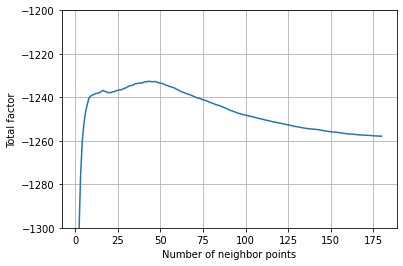

In [79]:
# plot ololo
plt.plot(neighbors, total_factor, '-')
plt.xlabel('Number of neighbor points')
plt.ylabel('Total factor')
plt.ylim([-1300, -1200])
plt.grid()
plt.show()

In [80]:
# index of the max value
neighbors_lof = max(range(len(total_factor)), key=total_factor.__getitem__)
print(neighbors_lof)

# number of ouliers
print(total_outliers[neighbors_lof-1])

42
13


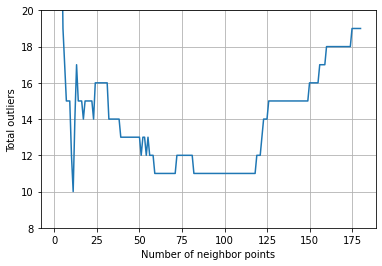

In [81]:
# plot ololo
plt.plot(neighbors, total_outliers, '-')
plt.xlabel('Number of neighbor points')
plt.ylabel('Total outliers')
plt.ylim([8, 20])
plt.grid()
plt.show()

Text(0.5, 1.0, 'Factor')

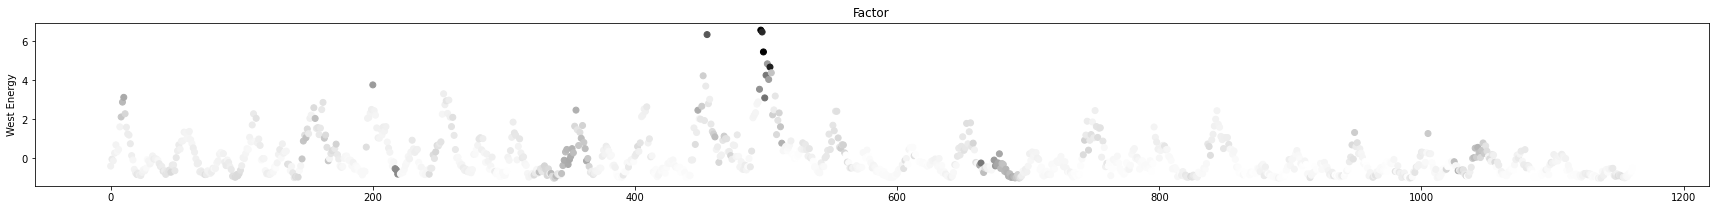

In [82]:
# factors
plt.figure(figsize=(30, 3))
plt.scatter(x=samples, y=adcpdata_scaled.WestEnergy, c=factors[neighbors_lof-1], cmap='gray')
plt.ylabel('West Energy')
plt.title("Factor")

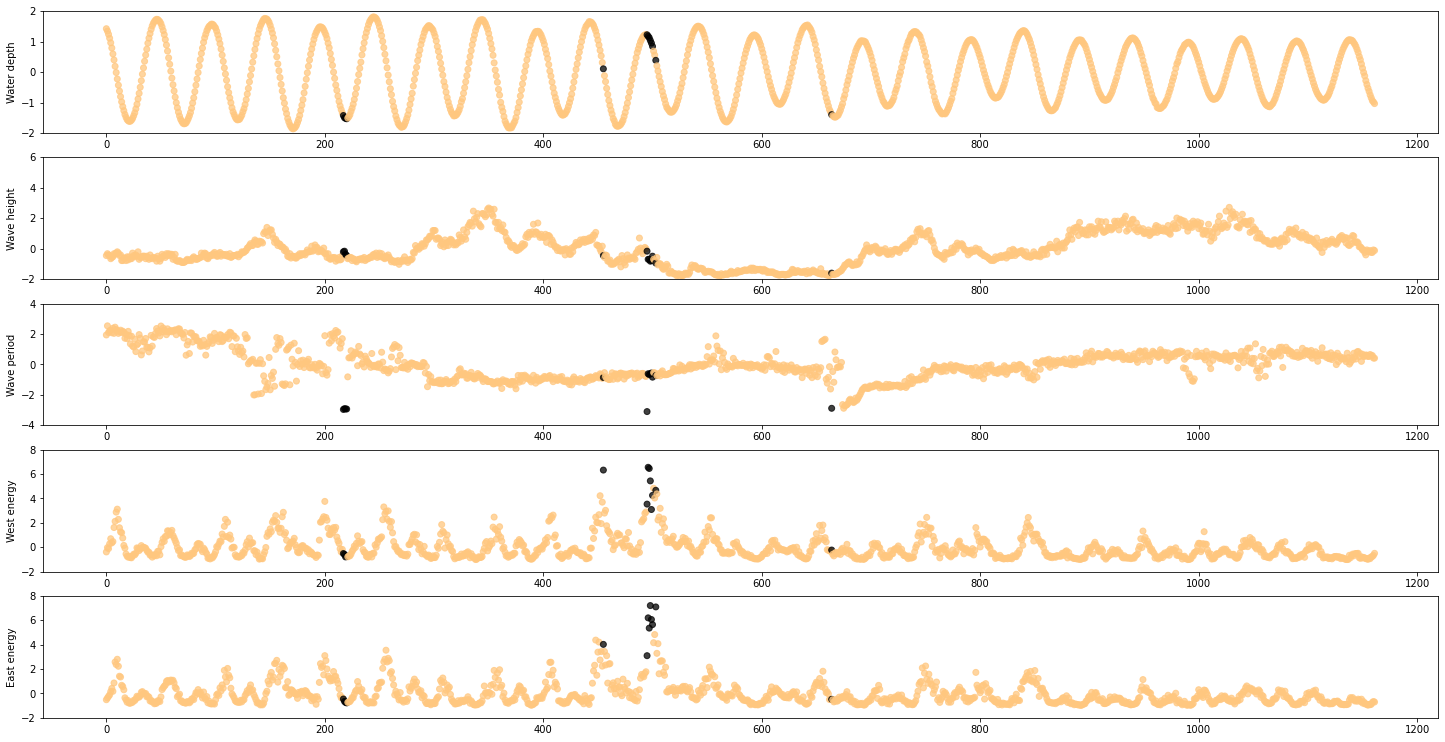

In [83]:
# visualize the adcp data
fig, axs = plt.subplots(5, figsize=(25, 13))

axs[0].scatter(x=samples, y=adcpdata_scaled.iloc[:,0], c=outliers[neighbors_lof-1], cmap='copper', alpha=0.75)
axs[0].set_ylabel('Water depth')
axs[0].set_ylim([-2, 2])

axs[1].scatter(x=samples, y=adcpdata_scaled.iloc[:,1], c=outliers[neighbors_lof-1], cmap='copper', alpha=0.75)
axs[1].set_ylabel('Wave height')
axs[1].set_ylim([-2, 6])

axs[2].scatter(x=samples, y=adcpdata_scaled.iloc[:,2], c=outliers[neighbors_lof-1], cmap='copper', alpha=0.75)
axs[2].set_ylabel('Wave period')
axs[2].set_ylim([-4, 4])

axs[3].scatter(x=samples, y=adcpdata_scaled.iloc[:,3], c=outliers[neighbors_lof-1], cmap='copper', alpha=0.75)
axs[3].set_ylabel('West energy')
axs[3].set_ylim([-2, 8])

axs[4].scatter(x=samples, y=adcpdata_scaled.iloc[:,4], c=outliers[neighbors_lof-1], cmap='copper', alpha=0.75)
axs[4].set_ylabel('East energy')
axs[4].set_ylim([-2, 8])

plt.show()

In [84]:
# final table
indeces_lof = np.where(outliers[neighbors_lof-1] == -1)
display(adcpdata.iloc[indeces_lof])

,Date,WaterDepth,WaveHeight,WavePeriod,WestEnergy,EastEnergy,Cluster
217,2019-05-18 20:29:58.915,6.590,0.265,2.3200,0.138710,0.153322,8
218,2019-05-18 20:44:58.910,6.519,0.270,2.4125,0.119482,0.097392,8
219,2019-05-18 20:59:58.905,6.496,0.245,2.3800,0.062736,0.071739,8
220,2019-05-18 21:14:58.900,6.483,0.235,2.3700,0.077718,0.061038,8
455,2019-05-21 07:59:57.725,8.142,0.235,6.0750,2.010858,1.440629,5
495,2019-05-21 17:59:57.525,9.273,0.270,2.0700,1.247442,1.174273,6
496,2019-05-21 18:14:57.520,9.225,0.205,6.5150,2.072987,2.065725,5
497,2019-05-21 18:29:57.515,9.174,0.205,6.4150,2.046979,1.823695,5
498,2019-05-21 18:44:57.510,9.084,0.190,6.5150,1.768551,2.355101,5
499,2019-05-21 18:59:57.505,8.996,0.195,6.6050,1.126666,2.026475,5


In [86]:
print(np.intersect1d(indices, indeces_lof))

[455]
